# [Readme]

This notebook executes the simulation of the model using the network and processed data, obtained at Steps 1-3 notebooks AND after running the simple node-based model. 

# SIMULATION (CLUSTERED NODE-BASED MODEL)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

from model_v3 import ClusteredNodeBasedModel

Below please provide the path to the network and the year/month of the data you would like to use during simulation.

In [2]:
year = 2019
month = 4

# INITIALISE THE MODEL
parameter_networks_list_path = f"./networks_for_node_model_{month:02d}-{year}.pkl"

node_based = ClusteredNodeBasedModel(parameter_networks_list_path)

# STORE THE RAW DATA
network_graphml_path = "./final_network/network_Belgium_full.graphml"
processed_json_data_dir = f'./infrabel_data_json/{year}-{month:02d}/'

node_based.store_data_from_directory(processed_json_data_dir)

Use .graphs_list to access the networks with raw node metadata for each day of the week


  0%|          | 0/30 [00:00<?, ?it/s]

Data is prepared. 
                Access .weekday_dict for the files sorted by days of the week
                Access .path_list for the full list of files


Choose the day of the week for which to make simultaion.

In [3]:
# CHOOSE THE DAY OF THE WEEK AND THE DATA FILE PATH AND UPLOAD THE DATA
day_of_week = 3
data_path = node_based.weekday_dict[day_of_week][1]
node_based.upload_raw_data(data_path)


Working with file :: 2019-04-11
Uploading raw train tracks...
SUCCESS! 
            Now you can use the .calculate_model_parameters to prepare model parameters for simulation and then .parse_raw_data to prepare the raw data


Provide the table of cluster ids of network nodes. Index of the dataframe must be nodes, columns indicate the number of clusters and entries inficate the cluster id the node is assigned to.  

Sample file is provided. Note that columns X/Y are not necessary in this code.

In [5]:
cluster_file_path = "Clustering_Kmeans.csv"
cluster_pd = pd.read_csv(cluster_file_path, index_col = "Name")
num_clusters = 16
cluster_dict = cluster_pd[str(num_clusters)].to_dict()

In [6]:
# CALCULATE MODEL PARAMETERS
g = node_based.graphs_list[day_of_week]
node_based.calculate_model_parameters(g, cluster_dict)

Model parameters are ready. You can start the simulation.
            Use .g_clustered to access the parameters of the cluster aggregated network


## Start

Now we can start the simulation. Choose the resolution parameter for discrete simulation. Note that very small numbers may affect the convergence of the algorithm. Good practice is to use 30 secs timeframe `dt`.

In [7]:
# GLOBAL RESOLUTION PARAMETER (IN SECONDS)
dt_data = 30 

node_based.parse_raw_data(dt_data)

Turning the data into time series of aggregated delays:   0%|          | 0/3588 [00:00<?, ?it/s]

Data is stored.
            Access .start_day_dt for the datetime timestamp of the current date
            Access .node_ts for the time series of aggregated delays on nodes
            Access .node_ts_smooth for their smoothed version
            Access .node_list for the ordered list of nodes, used to index the time series 

            Access .cluster_ts for the time series of aggregated delays on clusters
            Access .cluster_ts_smooth for their smoothed version
            Access .cluster_list for the ordered list of clusters, used to index the time series


In [8]:
# SIMULATION OF THE MODEL
from datetime import datetime, timedelta
from model_v3.utils import get_period_of_day

from model_v3.simulation import simulate_model

T_duration = 1*3600      # how long to simulate in seconds 
dt_simulation = 30       # simulation resolution
start_simulation_time = node_based.start_day_dt + timedelta(hours = 17, minutes = 10) 
end_simulation_time = start_simulation_time + timedelta(seconds = T_duration) 

start_t = int((start_simulation_time - node_based.start_day_dt).total_seconds()/dt_simulation)
end_t = int(((start_simulation_time - node_based.start_day_dt).total_seconds() + T_duration)/dt_simulation)


NUM_PERIODS = g.graph["num_periods"]
dp = get_period_of_day(NUM_PERIODS) # dictionary to map hours to day periods
simulate_hour = start_simulation_time.hour
index_hour = dp[simulate_hour]

G = node_based.G[index_hour]
B_vector = node_based.B_vector[index_hour]
g_clustered = node_based.g_clustered

initial_delay_vec = node_based.cluster_ts_smooth[start_t, :]

tt, X_dt, cluster_sim_delay_node_based_ts = simulate_model(g_clustered, G, B_vector, start_simulation_time, 
                                                        T_duration, dt_simulation, initial_delay_vec,
                                                        verbose = False)

## Plot

Plot the time series of delays at random set of L points during the simulation.

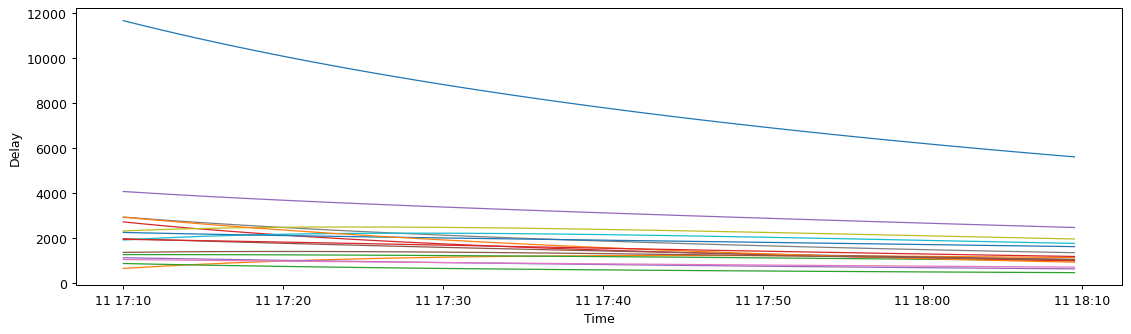

In [9]:
# PLOT THE SIMULATED TIME SERIES ON A NODE OF THE CLUSTERED GRAPH
_, N = cluster_sim_delay_node_based_ts.shape
L = 10
if N < 30:
    sample_points = list(range(N))
else:
    sample_points = np.random.randint(0, N, size = L )

fig = plt.figure(figsize = (15,4), dpi = 90)
for i in sample_points:
    plt.plot(X_dt, cluster_sim_delay_node_based_ts[:,i], lw = 1)
plt.xlabel("Time")
plt.ylabel("Delay")
plt.show()

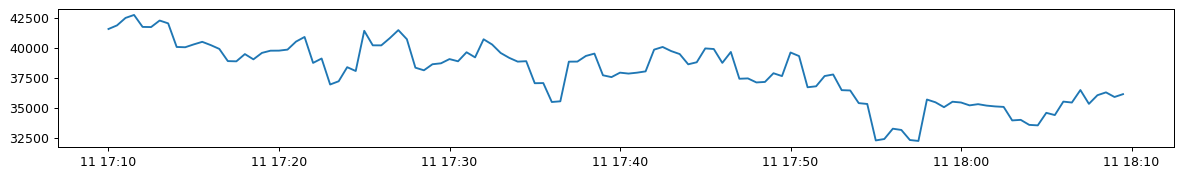

In [10]:
# PLOT THE EVOLUTION OF THE TOTAL DELAY REAL DATA
real_total_delay = np.sum(node_based.cluster_ts[start_t:end_t, :], axis = 1)

plt.figure(figsize = (16,2), dpi = 90)
plt.plot(X_dt, real_total_delay, lw = 1.5,)
plt.show()

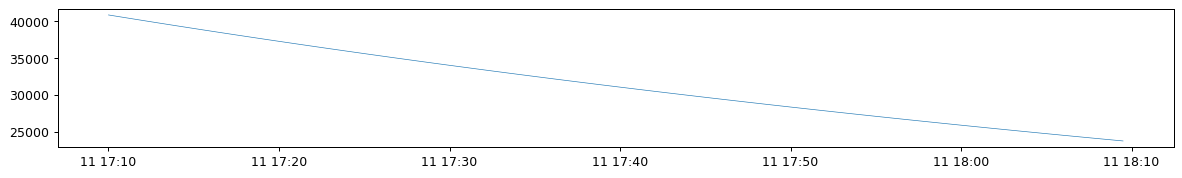

In [11]:
# PLOT THE EVOLUTION OF THE TOTAL DELAY IN THE SIMULATION
import matplotlib.pyplot as plt

real_total_delay = np.sum(cluster_sim_delay_node_based_ts, axis = 1)

plt.figure(figsize = (16,2), dpi = 90)
plt.plot(X_dt, real_total_delay, lw = 0.5, label = "reality")
# plt.axvline(simulation_start_dt, lw = 2, ls = "--", color = "red")
# plt.axvline(simulation_end_dt, lw = 2, ls = "--", color = "red")
plt.show()